In [1]:
import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian
from jax.lax import scan
from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np

from jax.experimental import stax, optimizers
from jax.flatten_util import ravel_pytree

import numpy as onp
from constrained_opt import AugmentedLagrangian
from IPython.display import clear_output
import matplotlib.pyplot as plt

/Users/ia285/miniconda3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/ia285/miniconda3/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/Users/ia285/miniconda3/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [2]:
x0 = np.array([0.54,0.3])
n,m,T = 2, 2, 100
x = np.ones((T, n)) * x0
# x = np.array(onp.random.uniform(0,1,size=(T, n)))
u = np.zeros((T, m))
z = np.concatenate([x, u], axis=1)


In [3]:
dt = 0.1
def f(x, u):
    B = np.array([
        [1.0,0.],
        [0.,1.]
    ])
    # B = np.array([
    #     [np.cos(x[2]), 0.,],
    #     [np.sin(x[2]), 0.],
    #     [0., 1.]
    # ])
    return x + dt*B@u


In [4]:
def p(x): # uniform distribution
    return np.exp(-60.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-60.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-60.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2)) \
                + np.exp(-60.5 * np.sum((x[:2] - np.array([0.75, 0.2]))**2))


def get_hk(k): # normalizing factor for basis function
    _hk = (2. * k + onp.sin(2 * k))/(4. * k)
    _hk = _hk.at[onp.isnan(_hk)].set(1.)
    return onp.sqrt(onp.prod(_hk))

def fk(x, k): # basis function
    return np.prod(np.cos(x*k))

k1, k2 = np.meshgrid(*[np.arange(0, 15, step=1)]*2)
k = np.stack([k1.ravel(), k2.ravel()]).T
k = np.pi*k

lamk = (1.+np.linalg.norm(k/np.pi,axis=1)**2)**(-4./2.)
# lamk = np.exp(-0.8 * np.linalg.norm(k, axis=1))
# lamk = np.ones((len(k), 1))
hk = []
for ki in k:
    hk.append(get_hk(ki))
hk = np.array(hk)

fk_vmap = lambda _x, _k: vmap(fk, in_axes=(0,None))(_x, _k)
def get_ck(tr, k):
    ck = np.mean(vmap(partial(fk_vmap, tr))(k), axis=1)
    ck = ck / hk
    return ck

X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T
phik = np.dot(vmap(fk_vmap, in_axes=(None, 0))(_s, k), vmap(p)(_s))
phik = phik/phik[0]
phik = phik/hk


def erg_dyn(z, x):
    z_dot = vmap(fk,  in_axes=(None, 0))(emap(x), k) - phik
    return z + dt * z_dot

def aug_dyn(v, u):
    x, z = v[:n], v[n:]
    z_next = erg_dyn(z, x)
    x_next = f(x, u)
    return (np.cat([x_next, z_next], axis=0), z_next-phik)

@jit
def sim(v0, u):
    return scan(aug_dyn, v0, u)

@vmap
def emap(x):
    return x[:2]

@vmap
def barrier_cost(e):
    return np.maximum(0, e-1) + np.maximum(0, -e)

@jit
def fourier_ergodic_loss(z, args):
    # x0 = args['x0']
    # xpast = args['xpast']
    x, u = z[:, :n], z[:, n:]
    # x = np.concatenate([x, xpast], axis=0)

    # _, x = sim(x0, u)
    # x = np.vstack([x, xpast])
    e = emap(x)
    ck = get_ck(e, k)
    return np.sum(lamk*np.square(phik - ck)) \
            + 0.1 * np.mean(u**2) + np.sum(barrier_cost(e))


In [5]:

def eq_constr(z, args):
    x, u = z[:, :n], z[:, n:]
    x0 = args['x0']
    return np.vstack([x[0]-x0, x[1:,:] - vmap(f)(x[:-1,:], u[:-1,:])])

def ineq_constr(z,args):
    return np.zeros(1)
    x, u = z[:, :n], z[:, n:]
    # e = emap(x)
    # ine1 = np.maximum(0, e-1) + np.maximum(0, -e)
    # return ine1
    # ine2 = np.abs(u) - 1.
    # return ine2
    # return np.concatenate([ine1.flatten(), ine2.flatten()])


In [6]:
args = {'x0': x0, 'xpast' : np.array([x0])}
problem = AugmentedLagrangian(z, fourier_ergodic_loss, eq_constr, ineq_constr, args, step_size=0.01, c=0.1)

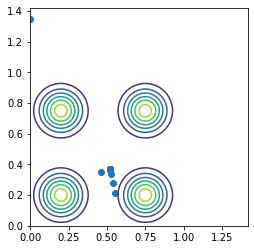

In [7]:
problem.solve(args, max_iter=1000)
sol = problem.get_solution()
clear_output(wait=True)
plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))
plt.scatter(sol['x'][:,0], sol['x'][:,1])
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.axis('square')
plt.show()

In [7]:
for _ in range(100):
    problem.solve(args, max_iter=100)

    clear_output(wait=True)
    plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))
    tr = sim(x0, problem.solution['x'].reshape(problem._x_shape))[1]
    # plt.scatter(problem.solution['x'][:,0], problem.solution['x'][:,1])
    plt.scatter(tr[:,0], tr[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axis('square')
    plt.show()

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

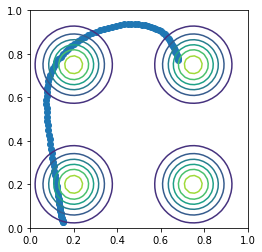

KeyboardInterrupt: 

In [25]:
traj = []
for tt in range(1000):
    
    problem.solve(args, max_iter=10)
    u = problem.solution['x']
    x0 = f(x0, u[0,:].copy())

    traj.append(x0.copy())
    args['xpast']=np.array(traj[-100:])
    args['x0'] = x0

    problem.solution['x'] = index_update(u, index[:-1,:], u[1:,:])
    problem.solution['x'] = index_update(u, index[-1,:], 0.)
    clear_output(wait=True)
    print('TI')
    if tt % 1 == 0:
        clear_output(wait=True)
        plt.contour(X, Y, vmap(p)(_s).reshape(X.shape))
        tr = sim(x0, problem.solution['x'])[1]
        # plt.scatter(problem.solution['x'][:,0], problem.solution['x'][:,1])
        plt.scatter(tr[:,0], tr[:,1])
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.axis('square')
        plt.pause(0.001)
        plt.show()

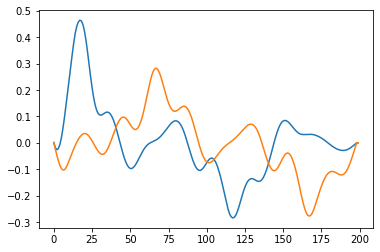

In [11]:
plt.plot(problem.solution['x'])

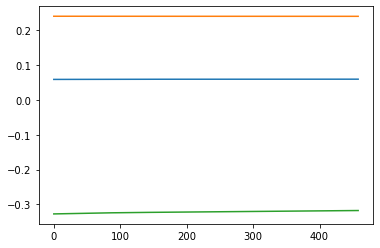

In [21]:
plt.plot(traj)